In [1]:
from pathlib import Path

import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import preseea_analysis

In [2]:
data_path = Path(preseea_analysis.__path__[0]).parent / 'data'

In [3]:
# Make sure data files are placed in data folder
base15 = pd.read_csv(data_path / 'base15.csv')
base95 = pd.read_csv(data_path / 'base95.csv')

In [4]:
# Concat base15 and base95 with an additional column to identify the dataset
base15['Corpus'] = 'Corpus15'
base95['Corpus'] = 'Corpus95'
base = pd.concat([base15, base95])

In [5]:
def get_counts(data, columns, y, percentage=False):
    """
    Get counts of the combinations of all unique values of the columns

    Parameters
    ----------
    data : pd.DataFrame
        Data to group
    columns : list
        Columns to group by
    y : str
        Column of the dependent variable
    percentage : bool
        If True, the counts will be transformed to percentages

    Returns
    -------
    counts : pd.DataFrame
        Counts of the data grouped by columns
    """

    uniques_y = data[y].unique()
    uniques_y.sort()
    counts = data.groupby(columns + [y]).size().reset_index(name='Counts')
    if percentage:
        # Get the percentage of the counts for the uniques_y[0]
        counts['Percentage'] = counts.groupby(columns)['Counts'].transform(
            lambda x: x / x.sum()
        )
        counts = counts.pivot_table(
            index=columns, columns=y, values='Percentage'
        ).reset_index()
        counts = counts.fillna(0)

        # Remove all columns that are not in columns or are unique_y[0]
        counts = counts.drop(uniques_y[1:], axis=1)

        # Replace the uniques_y[0] with the name of the column y
        counts.columns = [
            y if c == uniques_y[0] else c for c in counts.columns
        ]
    return counts

In [6]:
get_counts(
    base15,
    ['Tipodiscurso', 'Turnohabla', 'Correferencialidad'],
    'PRESENCIA',
    percentage=True,
)

,Tipodiscurso,Turnohabla,Correferencialidad,PRESENCIA
0,Argumentacion,Cambio de turno,Correferencial,0.250000
1,Argumentacion,Cambio de turno,No correferencial,0.400000
2,Argumentacion,Mismo turno,Correferencial,0.175926
3,Argumentacion,Mismo turno,No correferencial,0.325893
4,Descripcion,Cambio de turno,Correferencial,0.384615
5,Descripcion,Cambio de turno,No correferencial,0.369048
6,Descripcion,Mismo turno,Correferencial,0.147139
7,Descripcion,Mismo turno,No correferencial,0.278049
8,Dialogo,Cambio de turno,Correferencial,0.200000
9,Dialogo,Cambio de turno,No correferencial,0.372671


In [42]:
def formatter_percentage(x):
    return f'{abs(x):.1%}'


def formatter(x):
    return f'{abs(x):.0f}'


def bidirectional_hplot(data, columns, y, percentage=False, cmap=None):
    """
    Create bidirectional horizontal bar plot

    Parameters
    ----------
    data : pd.DataFrame
        Data to plot
    columns : list
        Columns to plot
    y : str
        Dependent variable

    Returns
    -------
    fig : matplotlib.figure.Figure
        Figure object
    ax : matplotlib.axes.Axes
        Axes object
    """

    if not cmap:
        cmap = plt.get_cmap('tab20c')

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(15, 7), layout='tight', dpi=300)

    bi_column = columns.pop(0)
    group_column = columns.pop(0)
    uniques_bi = data[bi_column].unique()
    uniques_group = data[group_column].unique()

    x = np.arange(len(uniques_group))
    width = 1 / (len(uniques_group) + 1)

    assert (
        len(data[bi_column].unique()) == 2
    ), f'The bidirectional column {bi_column} must have two unique values'

    # Create the bars
    for unique_bi in uniques_bi:
        columns_data = data[data[bi_column] == unique_bi]

        for groud_id, unique_group in enumerate(uniques_group):
            group_data = columns_data[
                columns_data[group_column] == unique_group
            ]
            group_counts = get_counts(
                group_data, columns, y, percentage=percentage
            )

            for index, row in group_counts.iterrows():
                cols = row.index[:-1]
                # Concat by ', ' the content of the columns to create the label
                label = ', '.join([f'{row[col]}' for col in cols])

                offset = width * int(index % (len(uniques_group))) - width / 2
                column_name = y if percentage else 'Counts'
                rects = ax.barh(
                    x[groud_id] + offset,
                    row[column_name]
                    * (1 if unique_bi == uniques_bi[0] else -1),
                    width,
                    label=label,
                    align='center',
                    color=cmap(list(range(len(group_counts))).index(index)),
                )
                # Make bar_labels format always positive
                format_fn = formatter_percentage if percentage else formatter
                ax.bar_label(rects, fmt=format_fn, padding=3)

    # Set x limit to be symmetrical
    max_value = max(np.abs(ax.get_xlim()))
    ax.set_xlim(-max_value, max_value)

    # Draw central vertical line
    ax.axvline(0, color='white', linewidth=2)

    # Change xticks to be always positive in both sides
    # ax.set_xticks(np.abs(ax.get_xticks()))
    ax.set_yticks(x + width, uniques_group)
    ax.set_xticklabels([format_fn(each) for each in np.abs(ax.get_xticks())])

    # Add the legend but without duplicates
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(
        by_label.values(),
        by_label.keys(),
        loc='center right',
        bbox_to_anchor=(1.4, 0.5),
    )

    plt.tight_layout()
    ax.margins(x=0.2)

    # Leave only bottom spine
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Set vertical grid
    plt.gca().xaxis.grid(True)
    # ax.xaxis.set_major_locator()
    ax.grid(axis='x', linestyle='--', alpha=0.6)

    # Print the words 'left' and 'right' below the x-axis labels
    ax.text(
        -max_value * 0.5 - len(uniques_bi[1]) * 0.005,
        -0.8,
        uniques_bi[1],
        fontsize=11,
        color='black',
        fontweight='bold',
    )
    ax.text(
        max_value * 0.5 - len(uniques_bi[0]) * 0.005,
        -0.8,
        uniques_bi[0],
        fontsize=11,
        color='black',
        fontweight='bold',
    )
    

    return fig, ax

/tmp/ipykernel_11961/1369920147.py:90: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([format_fn(each) for each in np.abs(ax.get_xticks())])


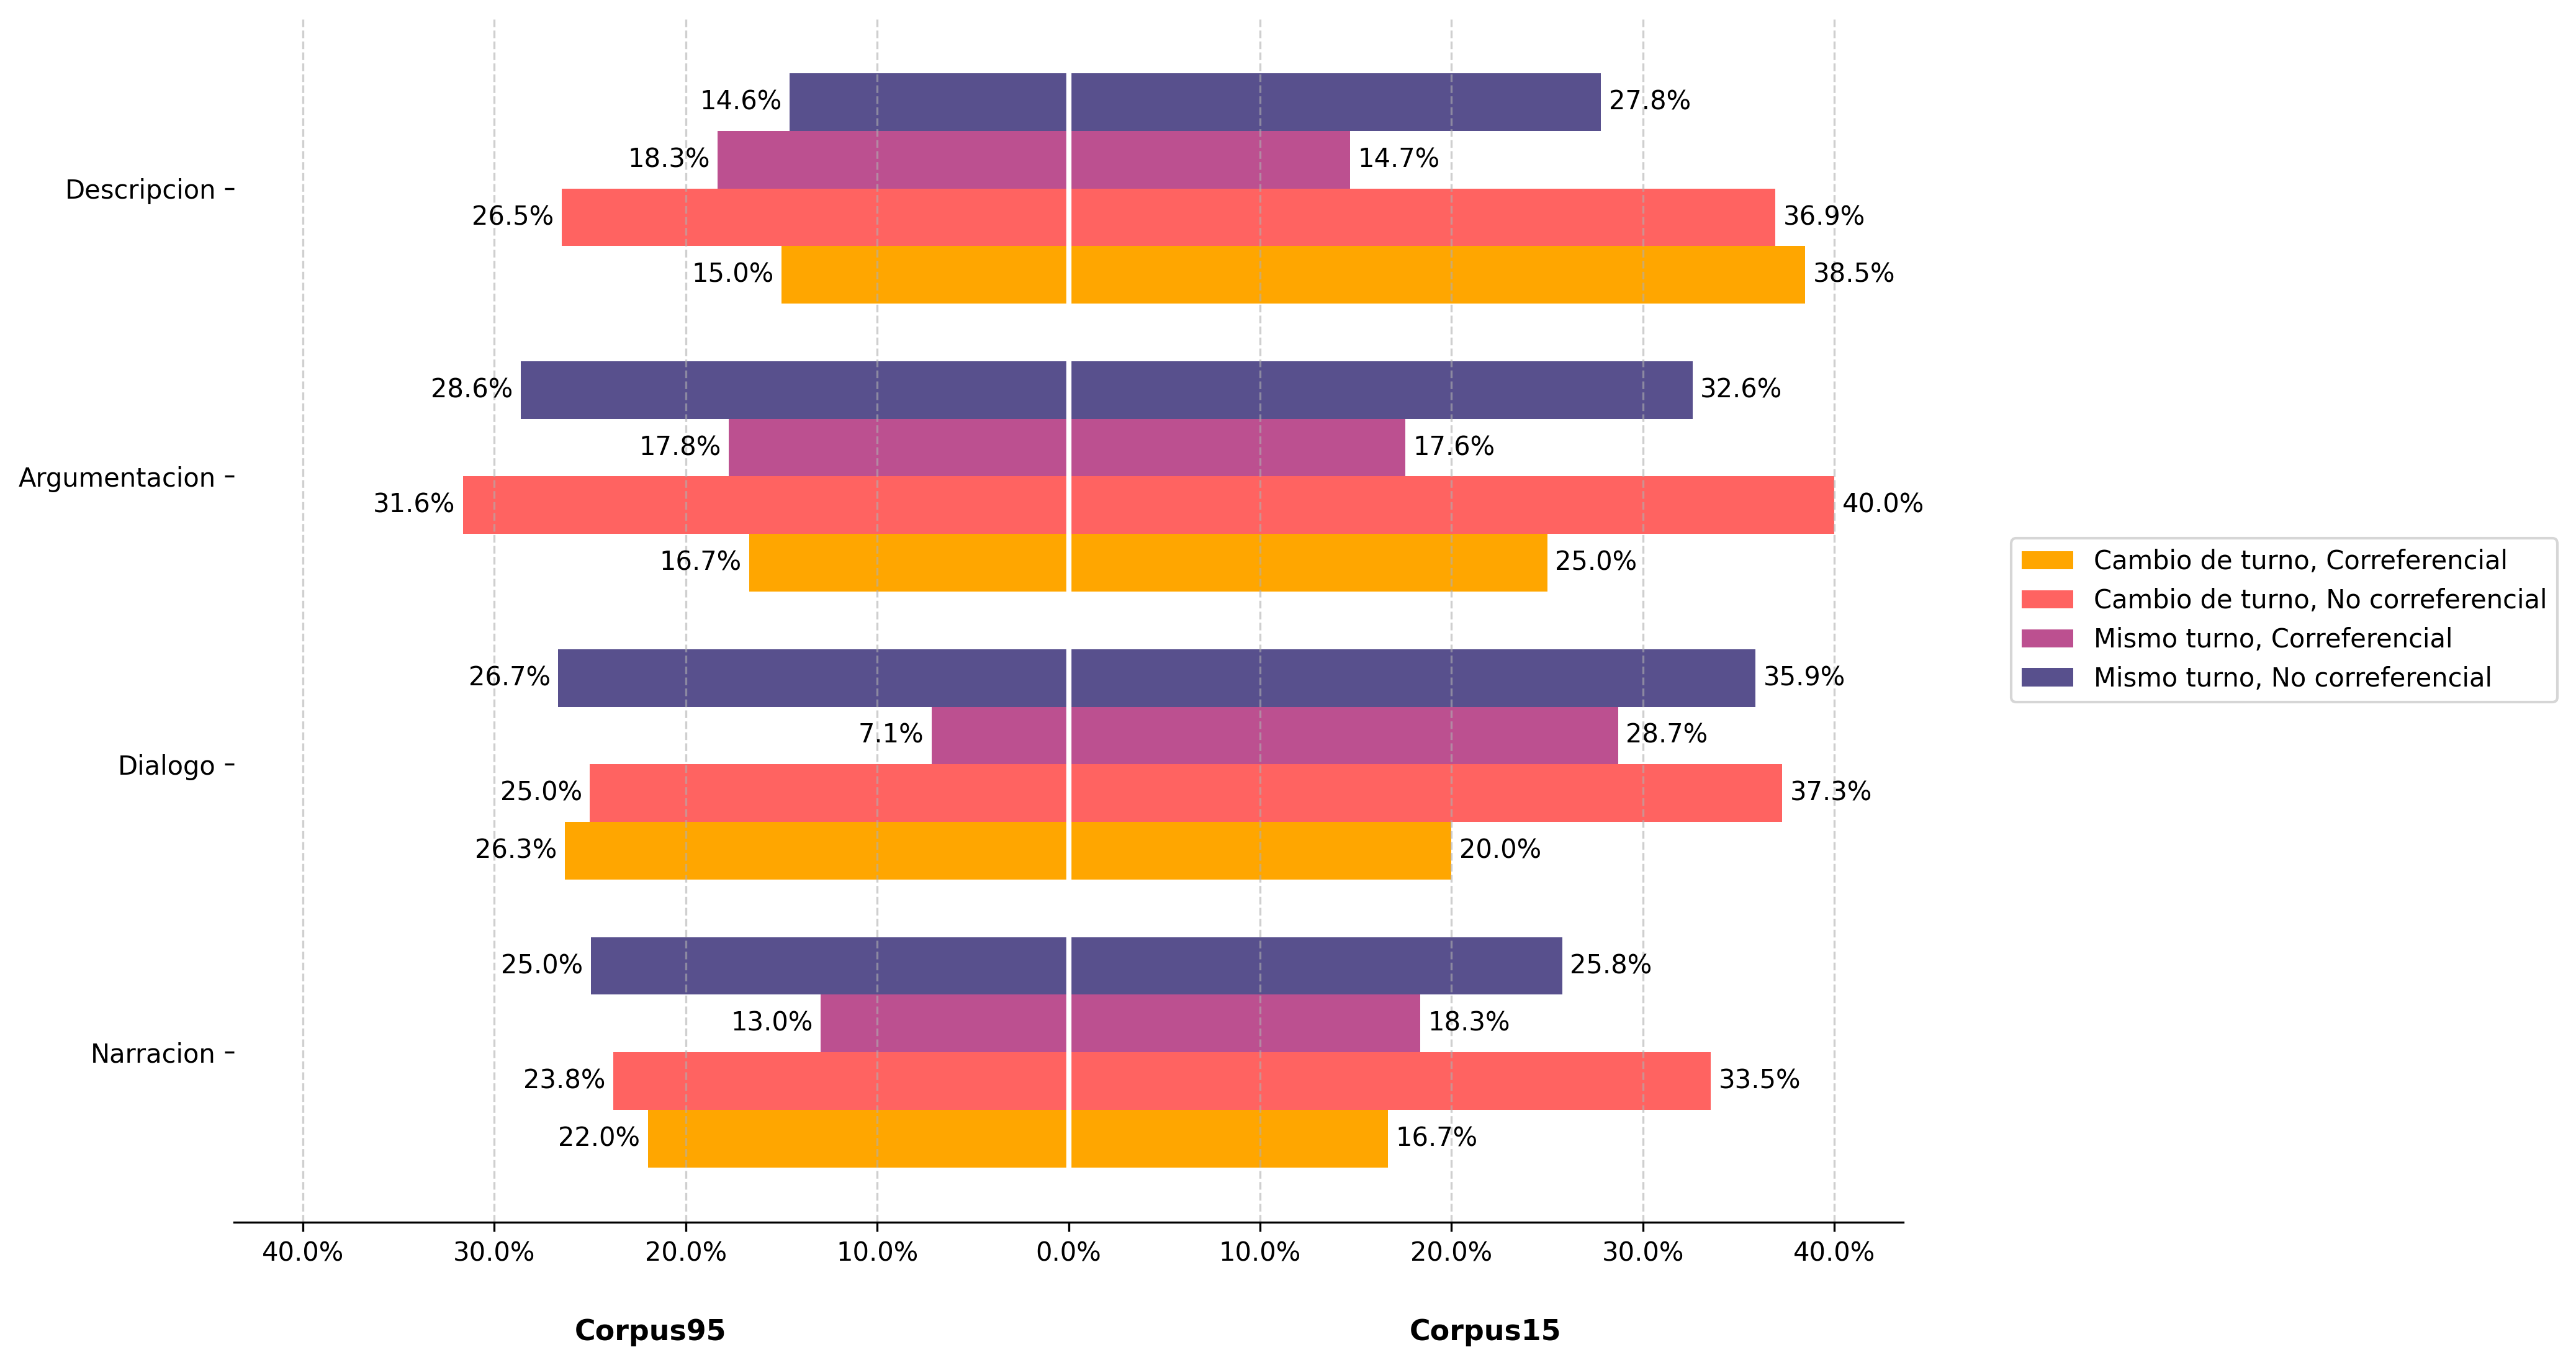

In [43]:
color_list = [
    'ffa600',
    'ff6361',
    'bc5090',
    '58508d',
]
# Convert to rgb format
color_list = [(int(c[0:2], 16) / 255, int(c[2:4], 16) / 255, int(c[4:6], 16) / 255) for c in color_list]
cmap = plt.cm.colors.ListedColormap(color_list)

# First column is for the left - right split, second column is for the bars
# clustering
columns = ['Corpus', 'Tipodiscurso', 'Turnohabla', 'Correferencialidad']
y = 'PRESENCIA'
fig, ax = bidirectional_hplot(base, columns, y, percentage=True, cmap=cmap)

<!--  -->

In [10]:
# Save plot
fig.savefig('plot.png', dpi=300, bbox_inches='tight')